In [412]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [413]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [435]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'YEAR', 'QUARTER', 'NAMEADDR']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    permits = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_STATUS_DATE'])
    permits = permits.drop_duplicates()
    permits = permits.set_index('PERMIT_ID')
    
    X = pd.read_csv("data_complete/Building_Permits_ISSUED.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_ISSUED_DATE'])
    X = X.drop_duplicates()
    X = X.set_index('PERMIT_ID')
    X.rename(columns = {'PERMIT_ISSUED_DATE':'PERMIT_DATE'}, inplace = True)
    return X, permits

permits, more_permits = loadPermits()
    
df = loadData()
df = df[columns]
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df.head()

,PERMIT_ID,UNITS,NET_UNITS,YEAR,QUARTER,NAMEADDR
1,N200505273609,1,1,2014,1,346 22nd Av
4,N200608179803,2,1,2014,1,536 40th Av
7,N200605111391,2,2,2014,1,1208 15th Av
11,N200904065665,6,6,2014,1,1701 09th Av
18,N201205180774,37,37,2014,1,25 Dolores St


In [436]:
permits = permits.join(more_permits, how='inner')

# keep only first and last entry for each building
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="first")
construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="last")

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))

data = data[~data.duplicated('PERMIT_ID')]
data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

# Duration = last 'construction' entry year/quarter - permit issue year/quarter in quarters
data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'NAMEADDR',# , 'PERMIT_DATE', 'YEAR_START', 'QUARTER_START'
             'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'COST']]#, 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data['COST'] = data['COST'].fillna(data['COST'].mean())
data.count()

565
529


UNITS                  529
NET_UNITS              529
YEAR_END               529
QUARTER_END            529
NAMEADDR               529
PERMIT_DATE_YEAR       529
PERMIT_DATE_QUARTER    529
DURATION               529
COST                   529
dtype: int64

In [437]:
# Split completed by 2017Q1 and still in construction by 2017Q1
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]

print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())

Completed by 2017:  354
Still in construction by 2017:  175


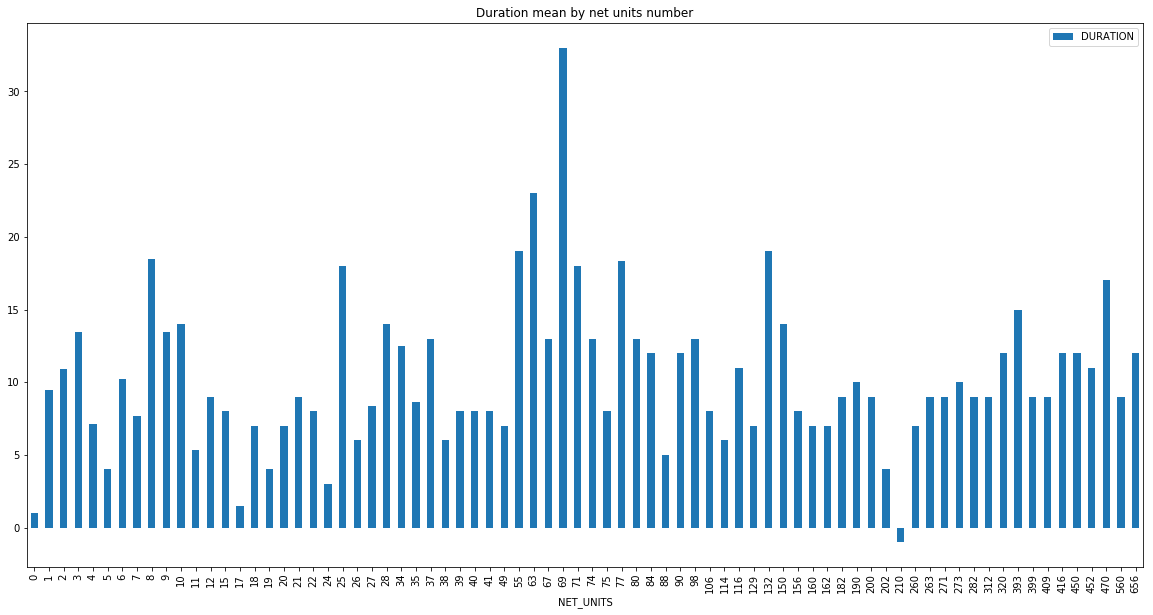

In [438]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10), title = "Duration mean by net units number")

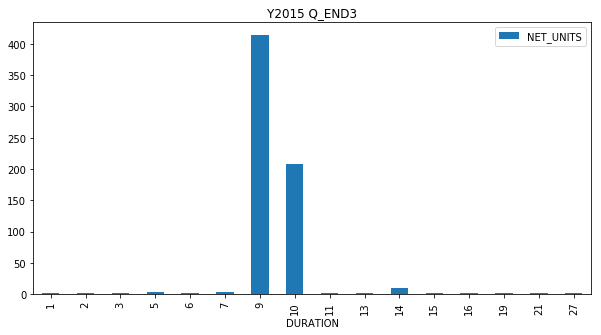

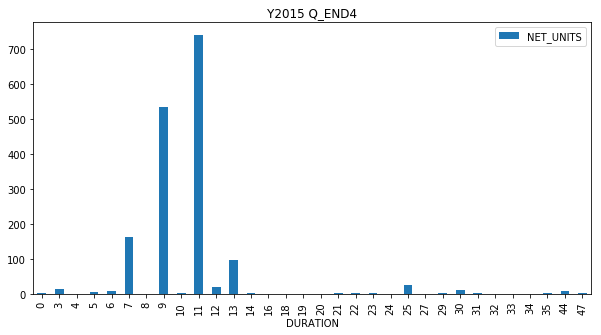

In [439]:
def plot_duration(year, quarter_end):
    d1 = complete[(complete['YEAR_END'] == year) & (complete['QUARTER_END'] == quarter_end)]
    grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(10,5), title = "Y" + str(year) + " Q_END" + str(quarter_end))

#plot_duration(2015, 1)
#plot_duration(2015, 2)
plot_duration(2015, 3)
plot_duration(2015, 4)

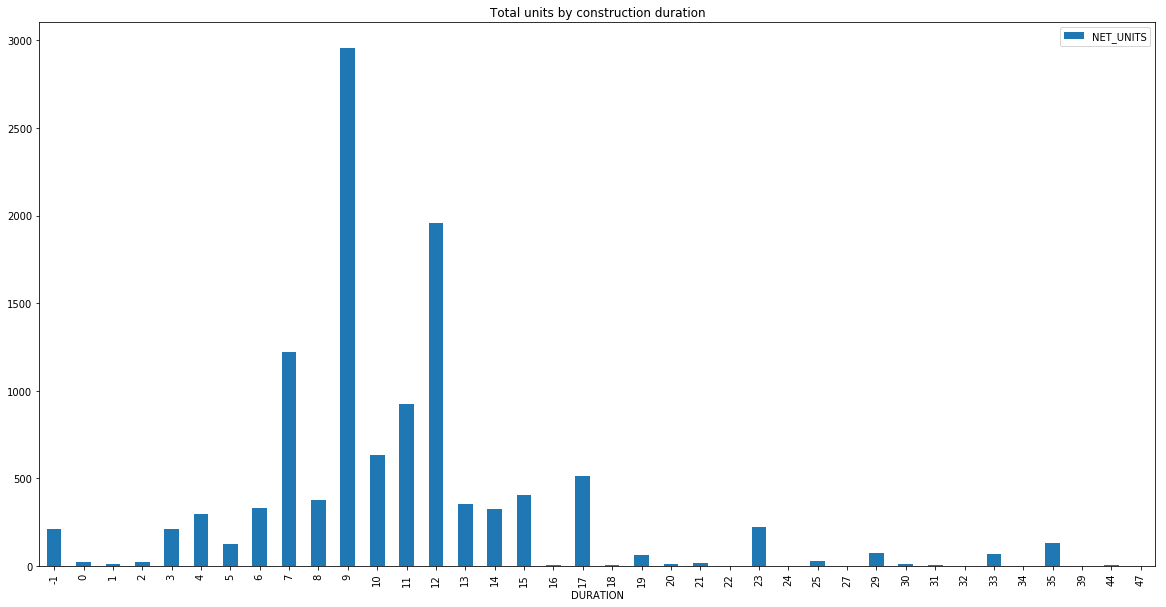

In [440]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Total units by construction duration")

In [441]:
def mean_std_norm(column):
    return (column - column.mean()) / column.std()

def min_max_norm(column):
    return (column - column.min())/(column.max() - column.min())

result = incomplete.copy()

complete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(complete['PERMIT_DATE_YEAR'])
incomplete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(incomplete['PERMIT_DATE_YEAR'])

complete['UNITS_NORM'] = mean_std_norm(complete['UNITS'])
incomplete['UNITS_NORM'] = mean_std_norm(incomplete['UNITS'])

complete['COST_NORM'] = mean_std_norm(complete['COST'])
incomplete['COST_NORM'] = mean_std_norm(incomplete['COST'])


columns_to_show = ['UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'DURATION_PREDICTED', 
                   'YEAR_END', 'QUARTER_END' , 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'COST', 'NAMEADDR']

In [442]:
X_train, X_val, y_train, y_val = train_test_split(
    complete, 
    complete['DURATION'], 
    test_size=0.3) 

def plot_diffs(pred, act):
    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    width = 0.4

    pred.plot(y = 'NET_UNITS', kind='bar', color='red', ax=ax, width=width, position=1)
    act.plot(y = 'NET_UNITS', kind='bar', color='blue', ax=ax2, width=width, position=0)

    ax.set_ylabel('Amount')
        
def train(model):
    return model.fit(X_train[['UNITS_NORM', 'PERMIT_DATE_YEAR_NORM', 'PERMIT_DATE_QUARTER', 'COST_NORM']], y_train)

def validate(model):
    print("Validation on historical data:")
    y_val_predicted = model.predict(X_val[['UNITS_NORM', 'PERMIT_DATE_YEAR_NORM', 'PERMIT_DATE_QUARTER', 'COST_NORM']])
    X_val['DURATION_PREDICTED'] = np.ceil(y_val_predicted)
    X_val['YEAR_END_PREDICTED'] = np.floor(X_val['PERMIT_DATE_YEAR'] + (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) / 4)
    X_val['QUARTER_END_PREDICTED'] = (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) % 4 + 1
    
    pred_sum = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum()
    act_sum = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].sum()
    plot_diffs(pred_sum, act_sum)    
    
    pred_mean = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].mean()
    act_mean = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].mean()
    plot_diffs(pred_mean, act_mean)
    
    # prediction error
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_val_predicted))
    
    
    
    display(X_val[columns_to_show].sort_values(by=['NET_UNITS'],ascending=False).head(15))
    
def predict_with_model(model):
    print("Prediction for not completed buildings:")
    duration_predicted = model.predict(incomplete[['UNITS_NORM', 'PERMIT_DATE_YEAR_NORM', 'PERMIT_DATE_QUARTER', 'COST_NORM']])
    result['DURATION_PREDICTED'] = np.ceil(duration_predicted)
    result['QUARTERS_LEFT'] = result['DURATION_PREDICTED'] - result['DURATION']
    result['YEAR_END_PREDICTED'] = np.floor(result['PERMIT_DATE_YEAR'] + (result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) / 4)
    result['QUARTER_END_PREDICTED'] = (result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) % 4 + 1

    prediction = result[columns_to_show + ['QUARTERS_LEFT']].sort_values(by=['NET_UNITS'],ascending=False)
    prediction.to_csv("data_complete/predictions.csv")
    
    grouped = prediction.sort_values(['NET_UNITS']).groupby(['QUARTERS_LEFT']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Net units delivered by quarters left")
    
    display(prediction.head(30))

Feature importances: 
 [ 0.0138926   0.91945196  0.01460042  0.05205503]
Validation on historical data:
Mean squared error: 11.11


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST,NAMEADDR
PERMIT_ID,,,,,,,,,,,,
N201306250394,560,560,2014,3,9,9.0,2016,3,2017.0,1.0,20000000.0,1 HENRY ADAMS ST
N201112070227,470,470,2012,3,17,12.0,2016,3,2015.0,4.0,25000000.0,POTRERO1010 (BLDG 1 OF 2)
N201208026344,399,399,2012,4,9,11.0,2014,4,2015.0,4.0,75000000.0,100 VAN NESS AV
N201009140800,320,320,2012,3,12,10.0,2015,2,2015.0,2.0,75000000.0,45 LANSING ST
N201106017208,282,282,2012,3,9,10.0,2014,3,2015.0,2.0,76510000.0,900 Folsom St
N201212246822,263,263,2013,4,9,9.0,2015,4,2016.0,2.0,106000000.0,718 LONG BRIDGE ST
N201404042522,200,200,2014,4,9,8.0,2016,4,2017.0,1.0,33857234.0,MISSION BAY BLOCK 7
N201106017202,182,182,2012,3,7,10.0,2014,1,2015.0,2.0,56408000.0,260 05th St
N201306280783,132,132,2014,3,3,8.0,2015,1,2016.0,4.0,17495000.0,144 KING ST


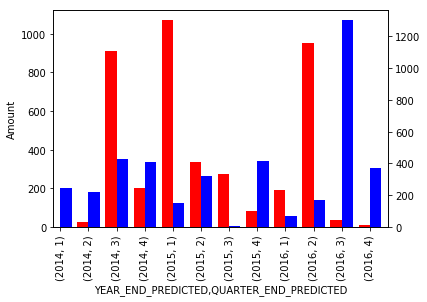

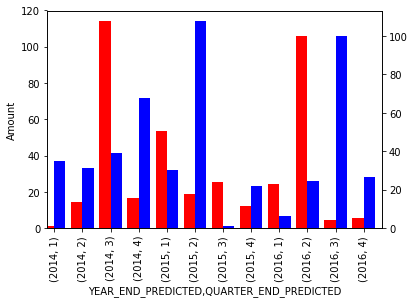

In [444]:
# with random forest

model = train(RandomForestRegressor(n_estimators=8, max_depth=6, criterion="mse", min_samples_split=6))
print('Feature importances: \n', model.feature_importances_)
validate(model)

In [428]:
predict_with_model(model)

Prediction for not completed buildings:


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Coefficients: 
 [ 0.02662095 -7.23041672 -0.71413857]
Validation on historical data:
Mean squared error: 11.30


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR
PERMIT_ID,,,,,,
N201112070227,470,470,2012,17,14.0,POTRERO1010 (BLDG 1 OF 2)
N200412211855,312,312,2012,9,14.0,425 First Street
N201212246822,263,263,2013,9,10.0,718 LONG BRIDGE ST
N201209119428,210,210,2015,-1,3.0,800 Brotherhood Way
N201409116118,202,202,2015,4,3.0,1095 MARKET ST
N201106017202,182,182,2012,7,14.0,260 05th St
N201307051190,162,162,2014,7,8.0,101 POLK ST
N201301319232,160,160,2013,7,10.0,1321 Mission Street
N200810315586,156,156,2013,8,10.0,1415 MISSION ST


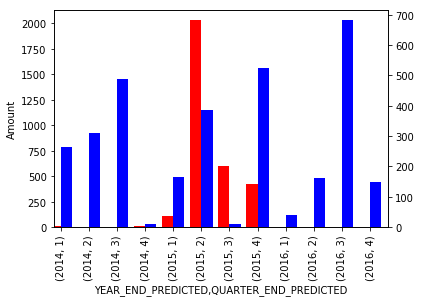

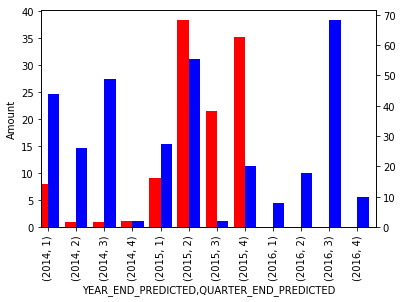

In [361]:
# with linear regression

model = train(linear_model.LinearRegression(fit_intercept=True, normalize=False))
print('Coefficients: \n', model.coef_)
validate(model)

Prediction for not completed buildings:


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR,QUARTERS_LEFT
PERMIT_ID,,,,,,,
N201603172392,1600,994,2016,2,5.0,HOPE SF POTRERO (BP ISSUED),3.0
N201309045886,557,557,2014,11,14.0,801 BRANNAN ST,3.0
N201209069080,550,550,2013,14,18.0,TRINITY PLAZA,4.0
N201406138394,431,431,2016,4,6.0,150 VAN NESS AV,2.0
N201404304554,418,418,2015,7,10.0,41 TEHAMA ST,3.0
N201406259383,326,326,2015,6,9.0,800 INDIANA ST,3.0
N201312234917,300,300,2015,8,11.0,1201 - 1225 TENNESSEE ST,3.0
N201408133775,198,198,2015,7,10.0,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,3.0
N201408133766,152,152,2015,7,10.0,MISSION BAY BLOCK 1 (RESIDENTIAL) CHANNEL,3.0


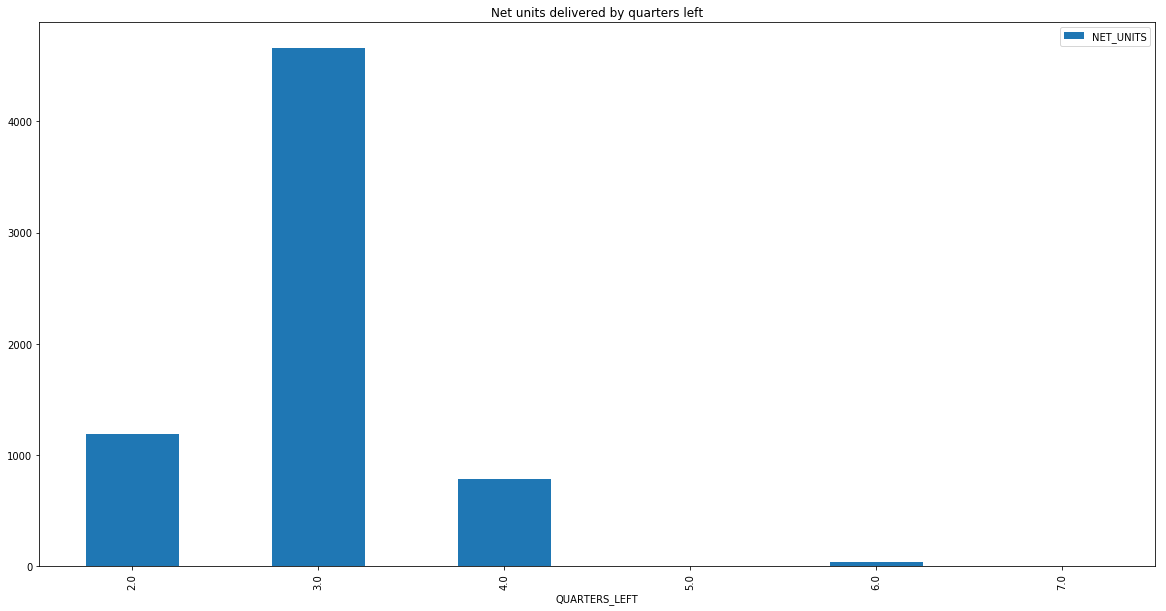

In [357]:
predict_with_model(model)